## Greg Hogg's CNN

***
`PREPARING THE MODEL`
***

In [105]:
import torch
import torchvision
import torchvision.transforms as transforms

In [136]:
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

In [106]:
torch.cuda.is_available()

False

In [107]:
device = 'mps' if torch.backends.mps.is_built() else 'cpu'
device

'mps'

In [108]:
transform = transforms.ToTensor()

batch_size = 8

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

In [109]:
train_iter = iter(trainset)

image, label = next(train_iter)

image.shape, label

(torch.Size([1, 28, 28]), 5)

In [110]:
torch.min(image).item(), torch.max(image).item()

(0.0, 1.0)

5


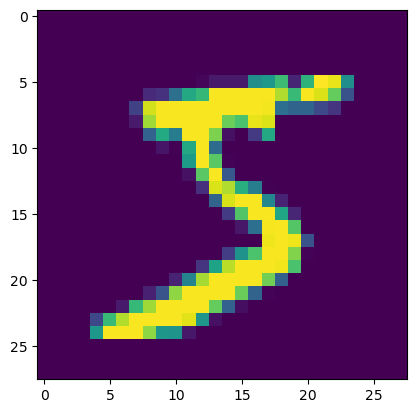

In [111]:
import matplotlib.pyplot as plt
import numpy as np

np_img = image.numpy()
print(label)
plt.imshow(np_img.reshape((28, 28, 1)))

In [112]:
len(trainset), len(testset)

(60000, 10000)

In [113]:
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])
len(trainset), len(valset), len(testset)

(50000, 10000, 10000)

In [114]:
print(f'Number of batches in the training set: {int(50000 / batch_size)}')

Number of batches in the training set: 6250


In [115]:
print(f'Number of batches in the validation set: {int(10000 / batch_size)}')

Number of batches in the validation set: 1250


In [116]:
type(trainset)

torch.utils.data.dataset.Subset

In [117]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [118]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=2)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=4096, out_features=1024)
        self.drop1 = nn.Dropout(p=0.3)

        self.fc2 = nn.Linear(in_features=1024, out_features=1024)
        self.drop2 = nn.Dropout(p=0.3)

        self.out = nn.Linear(in_features=1024, out_features=10)


    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = self.pool1(x)

      x = F.relu(self.conv2(x))
      x = self.pool2(x)

      x = F.relu(self.conv3(x))
      x = self.pool3(x)

      x = self.flatten(x)
      h = x

      x = F.relu(self.fc1(x))
      x = self.drop1(x)

      x = F.relu(self.fc2(x))
      x = self.drop2(x)

      x = self.out(x)

      return x, h

In [119]:
net = NeuralNet()
net.to(device)

NeuralNet(
  (conv1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(512, 1024, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=1024, out_features=10, bias=True)
)

In [120]:
for i, data in enumerate(trainloader):
    inputs, labels = data[0].to(device), data[1].to(device)
    print(f'input shape: {inputs.shape}')
    print(f'after network shape: {net(inputs)[0].shape}')
    break

input shape: torch.Size([8, 1, 28, 28])
after network shape: torch.Size([8, 10])


In [121]:
num_params = 0
for x in net.parameters():
  num_params += len(torch.flatten(x))

print(f'Number of parameters in the model: {num_params:,}')

Number of parameters in the model: 8,536,074


In [122]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [123]:
def train_one_epoch():
  net.train(True)

  running_loss = 0.0
  running_accuracy = 0.0

  for batch_index, data in enumerate(trainloader):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs, _ = net(inputs) # shape: [batch_size, 10]
    correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
    running_accuracy += correct / batch_size

    loss = criterion(outputs, labels)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()

    if batch_index % 500 == 499:  # print every 500 batches
      avg_loss_across_batches = running_loss / 500
      avg_acc_across_batches = (running_accuracy / 500) * 100
      print('Batch {0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1,
                                                          avg_loss_across_batches,
                                                          avg_acc_across_batches))
      running_loss = 0.0
      running_accuracy = 0.0


  print()

In [124]:
def validate_one_epoch():
    net.train(False)
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(valloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        with torch.no_grad():
            outputs, _ = net(inputs) # shape: [batch_size, 10]
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += correct / batch_size
            loss = criterion(outputs, labels) # One number, the average batch loss
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(valloader)
    avg_acc_across_batches = (running_accuracy / len(valloader)) * 100

    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches,
                                                            avg_acc_across_batches))
    print('***************************************************')
    print()

***
`TRAINING THE MODEL`
***

In [125]:
num_epochs = 10

for epoch_index in range(num_epochs):
    print(f'Epoch: {epoch_index + 1}\n')

    train_one_epoch()
    validate_one_epoch()


print('Finished Training')

Epoch: 1

Batch 500, Loss: 0.883, Accuracy: 69.7%
Batch 1000, Loss: 0.215, Accuracy: 93.6%
Batch 1500, Loss: 0.150, Accuracy: 95.7%
Batch 2000, Loss: 0.128, Accuracy: 95.9%
Batch 2500, Loss: 0.118, Accuracy: 96.3%
Batch 3000, Loss: 0.107, Accuracy: 96.8%
Batch 3500, Loss: 0.090, Accuracy: 97.2%
Batch 4000, Loss: 0.091, Accuracy: 97.3%
Batch 4500, Loss: 0.093, Accuracy: 97.3%
Batch 5000, Loss: 0.083, Accuracy: 97.4%
Batch 5500, Loss: 0.069, Accuracy: 97.7%
Batch 6000, Loss: 0.071, Accuracy: 97.7%

Val Loss: 0.050, Val Accuracy: 98.5%
***************************************************

Epoch: 2

Batch 500, Loss: 0.054, Accuracy: 98.2%
Batch 1000, Loss: 0.056, Accuracy: 98.2%
Batch 1500, Loss: 0.068, Accuracy: 98.1%
Batch 2000, Loss: 0.051, Accuracy: 98.5%
Batch 2500, Loss: 0.060, Accuracy: 98.1%
Batch 3000, Loss: 0.052, Accuracy: 98.4%
Batch 3500, Loss: 0.055, Accuracy: 98.5%
Batch 4000, Loss: 0.049, Accuracy: 98.6%
Batch 4500, Loss: 0.051, Accuracy: 98.3%
Batch 5000, Loss: 0.043, Accur

***
`ACCURACY OF THE MODEL`
***

In [126]:
def check_accuracy():
    net.train(False)
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(testloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        with torch.no_grad():
            outputs, _ = net(inputs) # shape: [batch_size, 10]
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += correct / batch_size
            loss = criterion(outputs, labels) # One number, the average batch loss
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(testloader)
    avg_acc_across_batches = (running_accuracy / len(testloader)) * 100

    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches,
                                                            avg_acc_across_batches))
    print('***************************************************')
    print()

In [127]:
check_accuracy()

Val Loss: 0.040, Val Accuracy: 99.2%
***************************************************



***
`ANALYZING THE MODEL`
***

In [128]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [132]:
images, labels, probs = get_predictions(net, testloader, device)

In [133]:
pred_labels = torch.argmax(probs, 1)

***
`CONFUSION MATRIX`
***

In [134]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

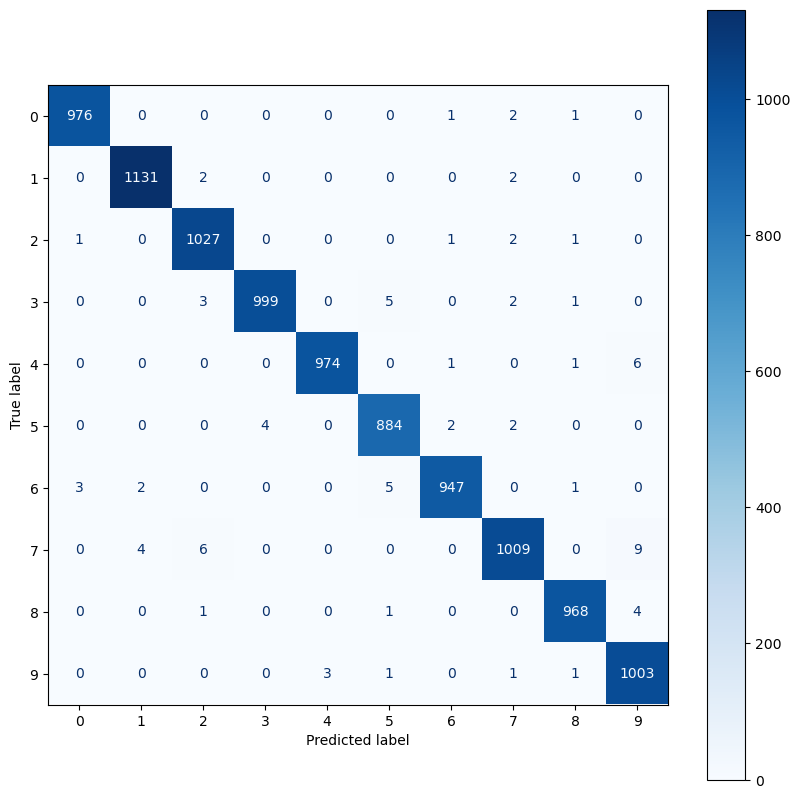

In [137]:
plot_confusion_matrix(labels, pred_labels)

***
`MOST INCORRECT GUESSES`
***

In [138]:
corrects = torch.eq(labels, pred_labels)

In [139]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [140]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

The mistakes look pretty reasonable. All the digits shown here are a bit off.

As mentioned in the previous notebook, the model is always trained to be incredibly confident with its predictions, so it's not unreasonable for it to be incredibly confident when it's wrong.

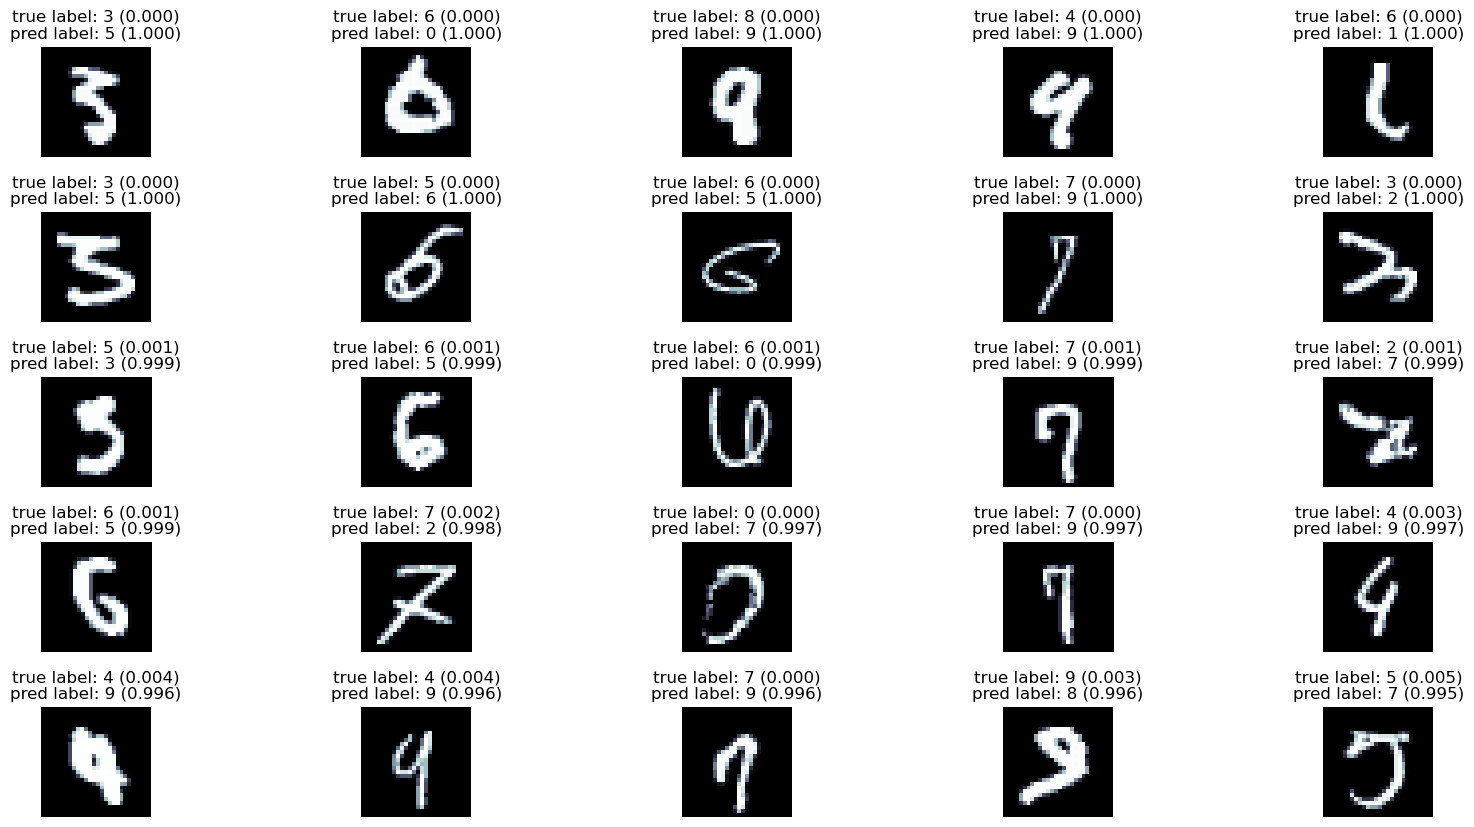

In [141]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

***
`LOWER DIMENSION VISUALIZATION`
***

In [142]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

In [144]:
outputs, intermediates, labels = get_representations(net,
                                                     trainloader,
                                                     device)

  0%|          | 0/6250 [00:00<?, ?it/s]

***
`PCA PLOT`
***

In [145]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [146]:
def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

In [147]:
output_pca_data = get_pca(outputs)

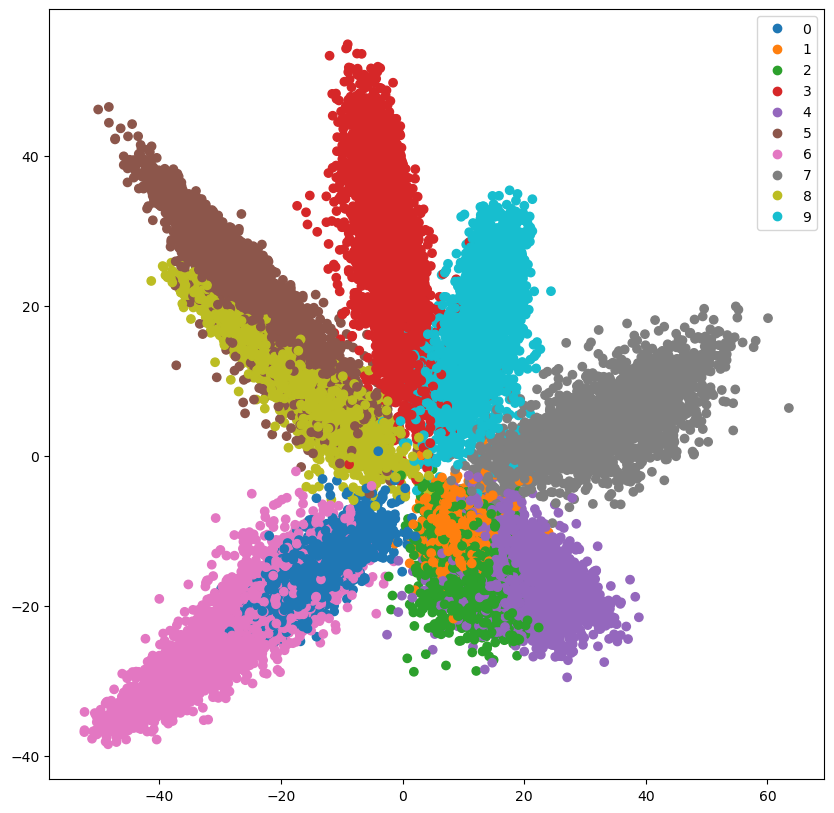

In [148]:
plot_representations(output_pca_data, labels)

Plotting the PCA representations of the intermediate values, just after the second set of convolutional and subsampling layers.

We can see that a lot of the classes are overlapped in one giant cluster. Intuitively, this makes sense, as the model has only extracted the features of the image so far and not yet passed them to the linear layers that will weight these features to make an actual prediction.

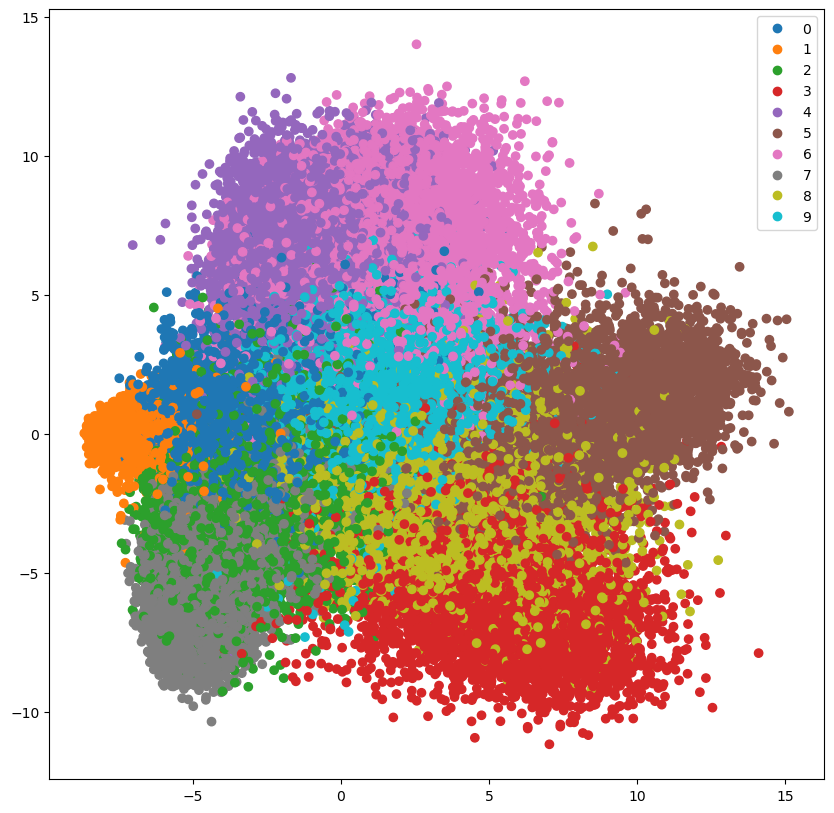

In [149]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

***
`t-SNE PLOT`
***

In [150]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

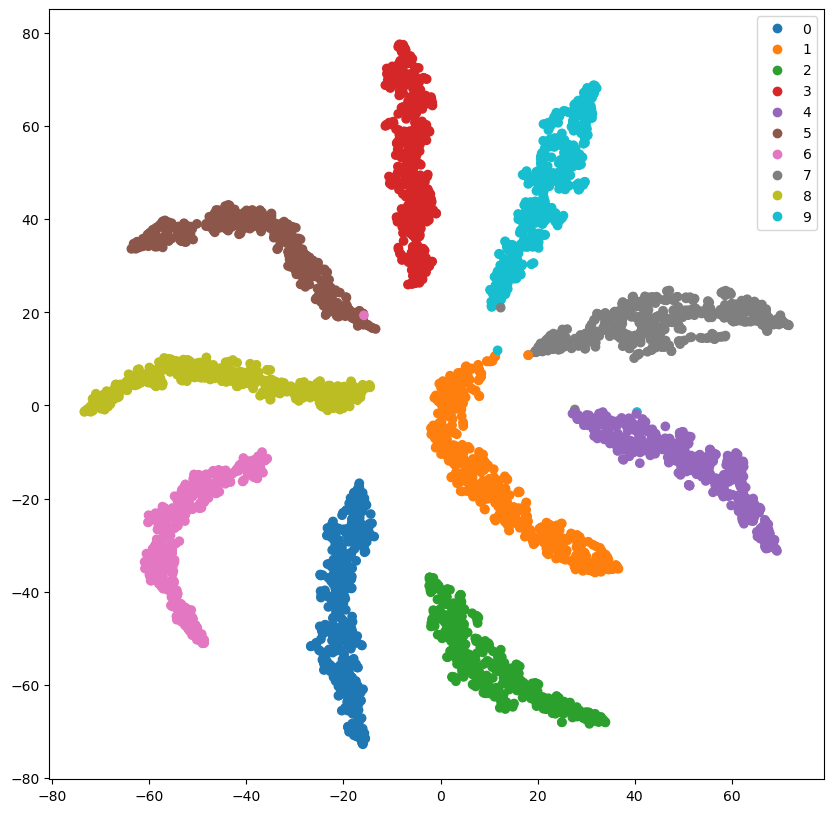

In [151]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, n_images=N_IMAGES)

Again, the intermediate representations are more clustered, which adds more evidence to the theory that this is just a representation of the extracted features before the linear layers have had a chance to weight up evidence on the presence or absence of certain extracted features.

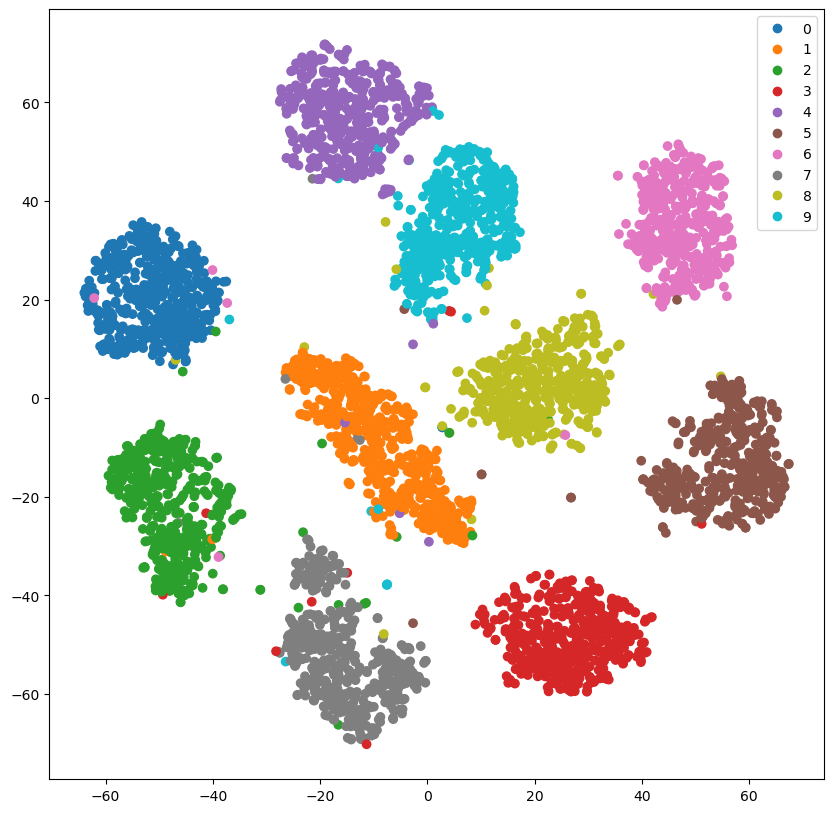

In [152]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images=N_IMAGES)

***
## Reference
Author: Greg Hogg

Link: https://colab.research.google.com/drive/1Pt5Dh0MON2G8Jo3MVJ0BV7CTUUm4NnHn?usp=sharing#scrollTo=XLFPG1sjmOdI

This notebook was adapted to use MNIST instead of Fashion MNIST.

Author: Ben Trevett

Link: https://github.com/bentrevett/pytorch-image-classification/blob/master/2_lenet.ipynb
***